<a href="https://colab.research.google.com/github/caiociardelli/sphglltools/blob/main/doc/1_B_splines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#B-splines

Author: Caio Ciardelli
<br>
<br>
If you use this Jupyter, please, cite the following paper:
<br>
<br>
Ciardelli, C., Bozdağ, E., Peter, D., and van der Lee, S., 2021. SphGLLTools: A toolbox for visualization of large seismic model files based on 3D spectral-element meshes. Computer & Geosciences, submitted.
<br>
<br>

####Cox-de Boor recursion formula

Basis splines (*B-splines*) are commonly used as basis functions to fit data sets smoothly. Just like polynomials, they can have any degree from zero to infinity. Cubic *B-splines* are the most used as they present a compromise between smoothness and flexibility.
<br>
<br>
Besides the degree, the number and position of the knots define the b-spline curves:
<br>
<br>
\begin{split}
  B_{k,\,0}&
  \,=\,
  \begin{cases}
    1\qquad \text{if}\qquad t_k \,\le\, x\, <\, t_{k\,+\,1}\\
    0\qquad \text{otherwise}  
  \end{cases}\\\\
  B_{k,\,n}&
  \,=\,\frac{x\,-\,t_k}{t_{k\,+\,n}\,-\,t_i}B_{k,\,n\,-\,1}(x)
  \,+\,\frac{t_{k\,+\,n\,+\,1}\,-\,x}{t_{k\,+\,n\,+\,1}\,-\,t_{k\,+\,1}}B_{k\,+\,1,\,n\,-\,1}(x)
\end{split}
<br>
<br>

####B-splines interpolation

Provided that we define the appropriate knots on the interval $[t_0,\,t_{N_k}]$, the B-splines form a complete set of functions on that interval, therefore can be used to expand a smooth function:
<br>
<br>
\begin{equation}
  S\,(x)
  \,=\,\sum_{k\,=\,0}^{Nk} c_k\,B_{k,\,n}\,(x),
\end{equation}
<br>
<br>
where
<br>
<br>
\begin{equation}
  c_k
  \,=\,{A_{k,\,k'}}^{-1}
  \,\int_{t_0}^{t_{Nk}} f\,(x)\,B_{k',\,n}\,(x)\,dx
  \quad\text{and}\quad
  A_{k,\,k'}
  \,=\,\int_{t_0}^{t_{Nk}} B_{k,\,n}\,(x)\,B_{k',\,n}\,(x)\,dx
\end{equation}
<br>
<br>

In [ ]:
def bSpl (k, n, t, x):
  """
  Evaluates B_{k,n}(x)
  """
  if n == 0:
    
    return 1.0 if t[k] <= x and x < t[k + 1] else 0.0
  
  else:
    
    a = t[k + n] - t[k]; b = t[k + n + 1] - t[k + 1]
    
    c1 = (x - t[k]) / a if a > 0 else 0
    c2 = (t[k + n + 1] - x) / b if b > 0 else 0

    return c1 * bSpl(k, n - 1, t, x) + c2 * bSpl (k + 1, n - 1, t, x)


def bSpline (k, n, t, x):
  """
  Evaluates B_{k,n}
  """
  lb = t[0]  * np.ones (n)
  rb = t[-1] * np.ones (n)

  t = np.append (np.append (lb, t), rb)

  y = np.empty (x.size)

  for i in range (x.size):

    y[i] = bSpl (k, n, t, x[i])

  return y


def bSplines (n, t, x):
  """
  Evaluates B_{n}
  """
  Nk = t.size + n - 1

  B = [bSpline (k, n, t, x) for k in range (Nk)]; B[-1][-1] = 1.0

  return B


def sB (n, c, B):
  """
  Evaluates S(x)
  """
  s = np.zeros (B[0].size)

  for k in range (len (B)):

    s += c[k] * B[k]

  return s

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Set the parameters below

# N: number of points

# n: degree
# t: positions of the knots
# c: control points

if __name__ == "__main__":

  N = 1000
  
  n = 3

  t = np.array ([0.00, 0.12, 0.19, 0.29, 0.41,
                 0.50, 0.59, 0.71, 0.82, 0.93, 1.00])
  c = np.array ([1.00, 1.00, 1.00, 1.00, 1.00,
                 1.00, 1.00, 1.00, 1.00, 1.00, 1.00])

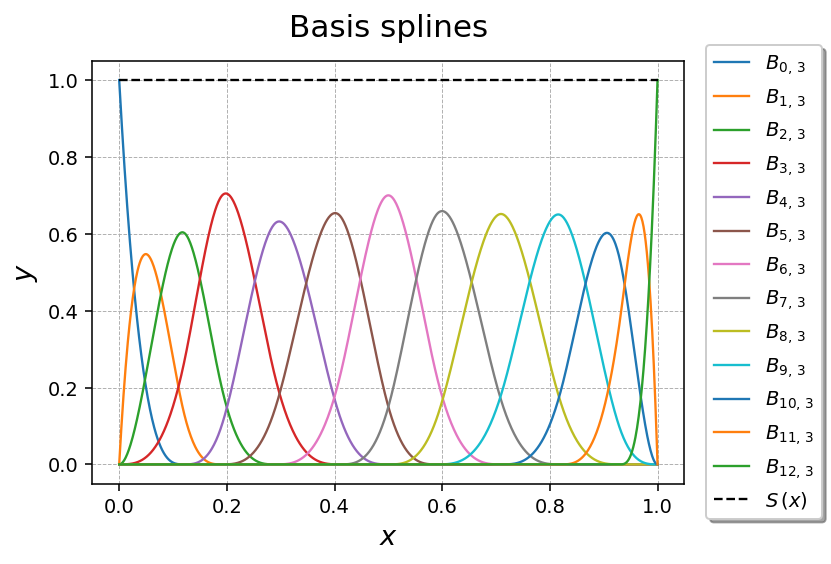

In [ ]:
if __name__ == "__main__":

  x = np.linspace (t[0], t[-1], N)

  lb = c[0]  * np.ones (n)
  rb = c[-1] * np.ones (n)

  c = np.append (np.append (lb, c), rb)

  B = bSplines (n, t, x)
  s = sB (n, c, B)

  fig = plt.figure (figsize = (6, 4), dpi = 140)

  for k in range (len (B)):

    plt.plot (x, B[k], linewidth = 1.2,
              label = r'$B_{{{},\,{}}}$'.format (k, n))

  plt.plot (x, s, color = 'black', linestyle = 'dashed',
            linewidth = 1.2, label = r'$S\,(x)$')
  plt.xlabel (r'$x$', fontsize = 14)
  plt.ylabel (r'$y$', fontsize = 14)
  plt.tick_params (axis = 'x', labelsize = 10)
  plt.tick_params (axis = 'y', labelsize = 10)
  fig.legend (loc = 'center right', shadow = True, framealpha = 1.0,
              handlelength = 1.8, fontsize = 10)
  plt.grid (linestyle = 'dashed', linewidth = 0.5)
  plt.title ('Basis splines', fontsize = 16, y = 1.03)

  plt.subplots_adjust (right = 0.83)

  plt.show ()

In [ ]:
from scipy.integrate import simps

In [ ]:
def assembleMatrix (B, n, x):
  """
  Assembles matrix A_{k,k'}
  """
  Nk = len (B)

  A = np.zeros ((Nk, Nk))

  for i in range (Nk):

    for j in range (Nk):

      if abs (i - j) > n: continue

      A[i, j] = simps (B[i] * B[j], x)
  
  return np.linalg.inv (A)


def coefficients (B, n, f, x):
  """
  Evaluates c_{k}
  """
  Nk = len (B)

  A = assembleMatrix (B, n, x)
  c = np.zeros (Nk)

  for i in range (Nk):

    for j in range (Nk):

      c[i] += A[i][j] * simps (B[j] * f (x), x)

  return c

In [ ]:
# Uncomment one of the following functions or define your own

if __name__ == "__main__":

  f = lambda x: 0.8 * np.cos (2 * np.pi * x) +\
                0.5 * np.sin (4 * np.pi * x) +\
                0.7 * np.cos (7 * np.pi * x)

#  f = lambda x: 1.3 * np.sin (3 * np.pi * x) +\
#                np.exp (-x ** 2) * np.cos (2 * np.pi * (x - 0.3))
  
#  f = lambda x: x * np.sin (5 * np.pi * x) +\
#                (x ** 2) * np.cos (7 * np.pi * x) +\
#                (x ** 3) * np.cos (9 * np.pi * x)

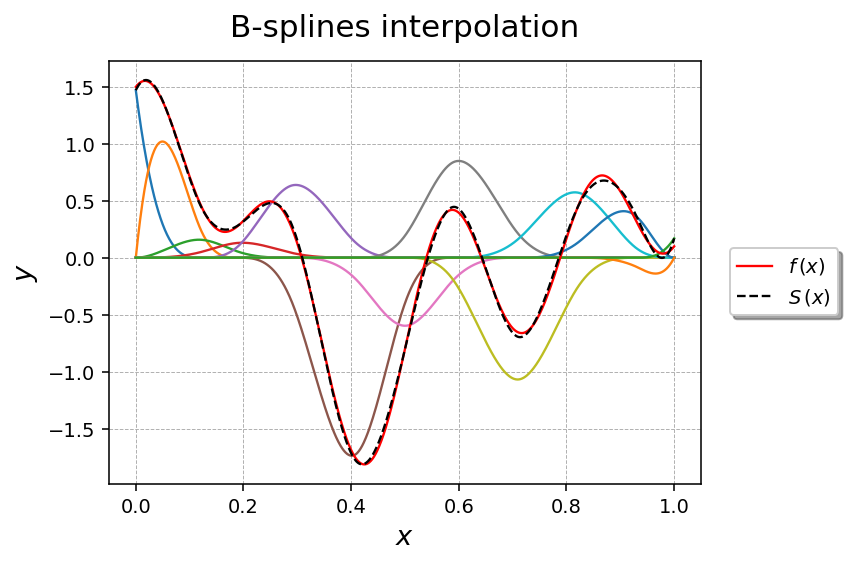

In [ ]:
if __name__ == "__main__":

  c = coefficients (B, n, f, x)
  s = sB (n, c, B)

  fig = plt.figure (figsize = (6, 4), dpi = 140)

  for k in range (len (B)):

    plt.plot (x, c[k] * B[k], linewidth = 1.2)

  plt.plot (x, f (x), color = 'red', linewidth = 1.2,
            label = r'$f\,(x)$')
  plt.plot (x, s, color = 'black', linestyle = 'dashed',
            linewidth = 1.2, label = r'$S\,(x)$')
  plt.xlabel (r'$x$', fontsize = 14)
  plt.ylabel (r'$y$', fontsize = 14)
  plt.tick_params (axis = 'x', labelsize = 10)
  plt.tick_params (axis = 'y', labelsize = 10)
  fig.legend (loc = 'center right', shadow = True, framealpha = 1.0,
              handlelength = 1.8, fontsize = 10)
  plt.grid (linestyle = 'dashed', linewidth = 0.5)
  plt.title ('B-splines interpolation', fontsize = 16, y = 1.03)

  plt.subplots_adjust (right = 0.83)

  plt.show ()

####References

“Basis Splines.” Basis Splines - GSL 2.6 Documentation, www.gnu.org/software/gsl/doc/html/bspline.html. [Accessed 10 July 2020]. 
<br>
<br>
“B-spline.” *Wikipedia*, Wikimedia Foundation, 27 Apr. 2020, https://en.wikipedia.org/wiki/B-spline [Accessed 10 July 2020]. 
<br>
<br>
de Boor, C., 2001. *A Practical Guide to Splines.* Revised Edition (with 32 figures). Springer-Verlag, pp. 87-90 ISBN 0-387-95366-3.
<br>
<br>
Lei, W., Ruan, Y., Bozdağ, E., Peter, D., Lefebvre, M., Komatitsch, D.,Tromp, J., Hill, J., Podhorszki, N., & Pugmire, D., 2020. *Global Adjoint Tomography - Model GLAD-M25*. Geophys. J. Int., ggaa253, https://doi.org/10.1093/gji/ggaa253